<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/imbalanced_classification/05_adjustment_weights_unbalanced_classes_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree
from sklearn.utils import class_weight


#**Settings**
---

In [6]:
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
random_seed = 12354

# **Tools**
---

In [7]:

def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

# **Data Dictionary**
---
- `Name`: nombre de la ventana de tiempo.
- `Netflows`: cantidad de netflows en la ventana de tiempo.
- `First_Protocol`: top 1 de protocolos usados en la ventana de tiempo.
- `Second_Protocol`: top 2 de protocolos usados en la ventana de tiempo.
- `Third_Protocol`: top 3 de protocolos usados en la ventana de tiempo.
- `p1_d`: 25% de los percentiles de todas las duraciones en la ventana de tiempo
- `p2_d`: 50% de los percentiles de todas las duraciones en la ventana de tiempo
- `p3_d`: 75% de los percentiles de todas las duraciones en la ventana de tiempo
- `duration`: duración total de la ventana de tiempo
- `max_d`: valor máximo de todas las duraciones en la ventana de tiempo.
- `min_d`: valor mínimo de todas las duraciones en la ventana de tiempo.
- `#packets`: número total de paquetes en la ventana de tiempo.
- `Avg_bps`: promedio de bits por segundo en la ventana de tiempo.
- `Avg_pps`: promedio de paquetes por segundo en la ventana de tiempo.
- `Avg_bpp`: promedio de bytes por paquete en la ventana de tiempo.
- `#Bytes`: número total de bytes en la ventana de tiempo.
- `#sp`: número total de puertos de origen usados en la ventana de tiempo.
- `#dp`: número total de puertos de destino usados en la ventana de tiempo.
- `first_sp`: top 1 de los puertos de origen en la ventana de tiempo.
- `second_sp`: top 2 de los puertos de origen en la ventana de tiempo.
- `third_sp`: top 3 de los puertos de origen en la ventana de tiempo.
- `first_dp`: top 1 de los puertos de destino en la ventana de tiempo.
- `second_dp`: top 2 de los puertos de destino en la ventana de tiempo.
- `third_dp`: top 3 de los puertos de destino en la ventana de tiempo.
- `p1_ip`: 25% de los percentiles de todas las entradas de paquetes en la ventana de tiempo.
- `p2_ip`: 50% de los percentiles de todas las entradas de paquetes en la ventana de tiempo.
- `p3_ip`: 75% de los percentiles de todas las entradas de paquetes en la ventana de tiempo.
- `p1_ib`: 25% de los percentiles de todas las entradas de bytes en la ventana de tiempo.
- `p2_ib`: 50% de los percentiles de todas las entradas de bytes en la ventana de tiempo.
- `p3_ib`: 75% de los percentiles de todas las entradas de bytes en la ventana de tiempo.
- `Type`: tipo de ventana de tiempo
  - `benignas`: 0
  - `bitcash`: 1
  - `bitcoin`: 2
  - `ethereum `: 3
  - `monero`: 4
  - `litecoin`: 5


# **Data**
---

In [8]:
url = 'https://raw.githubusercontent.com/Kaiziferr/datasets/main/cryptojacking.csv'
data = pd.read_csv(url, dtype=str).drop('Unnamed: 0', axis=1)

In [9]:
data[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']] = data[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']].astype('float64')


data[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']] = data[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']].astype('int64')


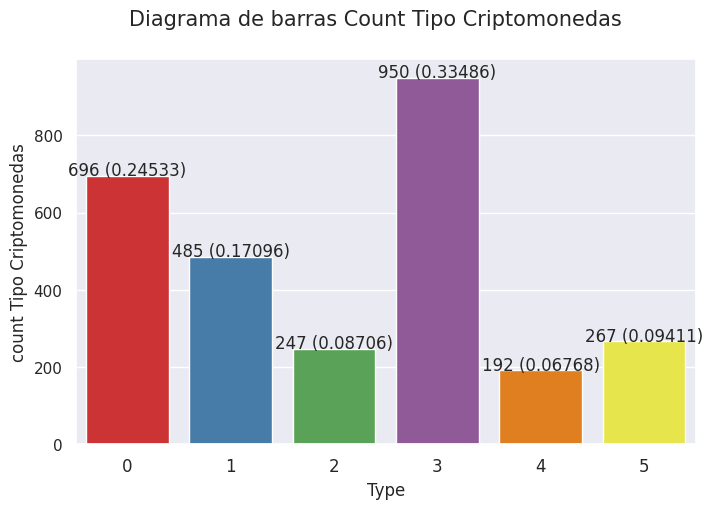

In [10]:
plot_bar(
    data,
    paleta=None,
    ejeX='Type',
    ejey='count Tipo Criptomonedas',
    title='Count Tipo Criptomonedas',
    p=True)

# **Split**
---

I take some numeric feature for data split

In [11]:
X = data[['p1_d', 'p2_d', 'min_d', '#packets', 'Avg_bpp', 'p2_ip', 'p3_ip',
       'p2_ib']]
y = data.iloc[:,-1].astype(int)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.85,
    random_state=random_seed,
    shuffle=True,
    stratify=y
)

#**Model**
---

Instantiate model with simple configurations.

In [14]:
model = DecisionTreeClassifier(
    criterion= "gini",
    max_depth= 12,
    min_samples_leaf= 1,
    min_samples_split= 7,
    random_state= random_seed,
    splitter= 'best'
)

In [15]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

A metric is created to assess the model's performance concerning minority classes.

In [16]:
score_recall = metrics.make_scorer(
    metrics.recall_score,
    labels=[2, 4, 5],
    average='micro'
)

Performance of model

In [17]:
cv_scores = cross_val_score(
    estimator = model,
    X         = X,
    y         = y,
    scoring   = score_recall,
    cv        = 10
)

In [18]:
cv_scores

array([0.88571429, 0.94366197, 0.78873239, 0.87323944, 0.90140845,
       0.90140845, 0.83098592, 0.87142857, 0.84285714, 0.85714286])

In [19]:
print(f"Mean of cross validation: {cv_scores.mean()}")
print(f"Cross Validation Metric Deviation: {cv_scores.std()}")

Mean of cross validation: 0.8696579476861167
Cross Validation Metric Deviation: 0.04084842043531734


Final prediction performance

In [20]:
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
metrics.recall_score(
    y_test,
    y_predict,
    labels=[2, 4, 5],
    average='micro')

0.8113207547169812

# **Setting Class Weights**
---

The weights balance


In [21]:
weight = class_weight.compute_class_weight(
    class_weight='balanced',
    classes = np.unique(y),
    y=y
)

weight = dict(zip(np.unique(y), weight))
weight

{0: 0.6793582375478927,
 1: 0.974914089347079,
 2: 1.9143049932523617,
 3: 0.49771929824561406,
 4: 2.462673611111111,
 5: 1.7709113607990012}

In [22]:
model2 = DecisionTreeClassifier(
    criterion= "gini",
    max_depth= 12,
    min_samples_leaf= 1,
    min_samples_split= 7,
    random_state= random_seed,
    splitter= 'best',
    class_weight = weight
)

Performance of model

In [23]:
cv_scores = cross_val_score(
    estimator = model2,
    X         = X,
    y         = y,
    scoring   = score_recall,
    cv        = 10
)

In [24]:
cv_scores

array([0.85714286, 0.88732394, 0.81690141, 0.87323944, 0.90140845,
       0.90140845, 0.87323944, 0.91428571, 0.91428571, 0.87142857])

In [25]:
print(f"Mean of cross validation: {cv_scores.mean()}")
print(f"Cross Validation Metric Deviation: {cv_scores.std()}")

Mean of cross validation: 0.8810663983903421
Cross Validation Metric Deviation: 0.028246580472789384


In [26]:
model2.fit(X_train, y_train)
y_predict = model2.predict(X_test)
metrics.recall_score(
    y_test,
    y_predict,
    labels=[2, 4, 5],
    average='micro')

0.839622641509434

The model had a small improvement, where it went from 0.81 to 0.84